In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

from ds_utils.db.connectors import PivotDW

pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_rows', 100)
pd.set_option('display.min_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', True)

# pd.set_option('precision', 2)

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.style.use('fivethirtyeight')


# pd.option_context('display.max_rows', None, 'display.max_columns', None)

print(plt.style.available)


['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


In [5]:
# This is a query on a materialized view.  Refresh once a day.
refresh_view = False

"""
  plan_category  sales
0         180x1  38766
1         180x2    981
2         180x4  17970
3         364x1  16388
4         364x2    884
5         364x3    106
6         364x4      2
7          90x1   1906
8          90x4      2



"""

stm_query = """
    SELECT
        app_pid,
        datetime_created::DATE AS sold_date,
        date_part(MONTH, datetime_created::DATE)::INT AS sold_month,
        date_part(YEAR, datetime_created::DATE)::INT AS sold_year,
        effective_date,
        expiration_date,
        termination_date,
        plan_type_order,
        CASE WHEN plan_type IN ('30x1', '60x1', '90x1') THEN '90x1' ELSE plan_type END AS plan_type,
        plan_group,
        CASE WHEN plan_group = '364+' THEN 364 ELSE duration_sold END AS duration_sold,
        CASE WHEN plan_group = '364+' AND  duration_inforce >= 364 THEN 364 ELSE duration_inforce END AS duration_inforce,
        ((CASE WHEN plan_group = '364+' AND  duration_inforce >= 364 THEN 364 ELSE duration_inforce END)::NUMERIC / 
            (CASE WHEN plan_group = '364+' THEN 364 ELSE duration_sold END)::NUMERIC)::NUMERIC(5,4) AS inforce_percent,
        asof_date,
        has_dental,
        has_vision,
        has_supp,
        state,
        plan_members,
        spousal_members,
        children_members,
        primary_age,
        spouse_age,
        child_age_average
    FROM tracking.app_premium_revised
    WHERE ((plan_group = '364+' AND duration_inforce >= 364) OR status = 'LAPSED')
        AND is_prepaid = 0
        AND product_type IN ('STM', 'BTM')
        AND plan_type IN ('180x1', '180x2', '30x1', '60x1', '90x1', '90x2', '90x4', '364x1', '364x2', '364x3')
    ;
"""

with PivotDW() as db_context:
    
    if refresh_view:
        db_context.exec("REFRESH MATERIALIZED VIEW tracking.app_premium_revised;")
        
    stm_df = db_context.to_df(
        stm_query, 
        parse_dates=['sold_date', 'effective_date', 'expiration_date', 'termination_date', 'asof_date']
    )

print(len(stm_df))
stm_df.head()


INFO:root:query: SELECT app_pid, datetime_created::DATE AS sold_date, date_pa... executed in 22.02 seconds


81247


,app_pid,sold_date,sold_month,sold_year,effective_date,expiration_date,termination_date,plan_type_order,plan_type,plan_group,duration_sold,duration_inforce,inforce_percent,asof_date,has_dental,has_vision,has_supp,state,plan_members,spousal_members,children_members,primary_age,spouse_age,child_age_average
0,186762,2018-12-13,12,2018,2018-12-14,2019-12-12,2019-12-12,5,364x1,364,364,363,0.9972,2021-03-26,0,0,0,NC,1,0,0,49.7700,nan,nan
1,207263,2019-05-21,5,2019,2019-05-22,2020-05-19,2019-06-21,5,364x1,364,364,30,0.0824,2021-03-26,0,0,0,TX,1,0,0,19.6200,nan,nan
2,195305,2019-02-06,2,2019,2019-02-07,2020-02-05,NaT,5,364x1,364,364,364,1.0000,2021-03-26,0,0,0,TX,1,0,0,28.7000,nan,nan
3,206006,2019-05-11,5,2019,2019-05-12,2019-11-07,2019-06-11,4,180x1,180,180,30,0.1666,2021-03-26,0,0,0,TN,1,0,0,34.1100,nan,nan
4,211665,2019-06-28,6,2019,2019-06-29,2020-06-26,NaT,5,364x1,364,364,364,1.0000,2021-03-26,0,0,0,GA,1,0,0,23.9800,nan,nan


In [6]:
model_df = stm_df[[
    'app_pid', 'plan_type_order', 'plan_type', 'plan_group', 'duration_sold', 'duration_inforce', 'inforce_percent',
    'sold_month', 'sold_year', 'has_dental', 'has_vision', 'has_supp', 'plan_members', 'primary_age', 
    'child_age_average', 'state'
]]

model_df.head()



,app_pid,plan_type_order,plan_type,plan_group,duration_sold,duration_inforce,inforce_percent,sold_month,sold_year,has_dental,has_vision,has_supp,plan_members,primary_age,child_age_average,state
0,186762,5,364x1,364,364,363,0.9972,12,2018,0,0,0,1,49.7700,nan,NC
1,207263,5,364x1,364,364,30,0.0824,5,2019,0,0,0,1,19.6200,nan,TX
2,195305,5,364x1,364,364,364,1.0000,2,2019,0,0,0,1,28.7000,nan,TX
3,206006,4,180x1,180,180,30,0.1666,5,2019,0,0,0,1,34.1100,nan,TN
4,211665,5,364x1,364,364,364,1.0000,6,2019,0,0,0,1,23.9800,nan,GA


In [7]:
stm_df.groupby('plan_type').size().reset_index(name='policies')

,plan_type,policies
0,180x1,27677
1,180x2,524
2,364x1,20381
3,364x2,1804
4,364x3,472
5,90x1,10325
6,90x2,633
7,90x4,19431


<AxesSubplot:xlabel='plan_type_order,plan_group'>

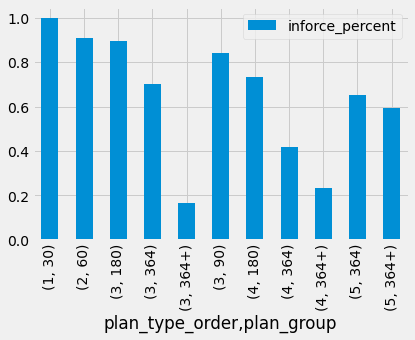

In [8]:
model_df.groupby(['plan_type_order', 'plan_group']).mean()[['inforce_percent']].plot.bar()

<AxesSubplot:xlabel='plan_type_order,plan_type'>

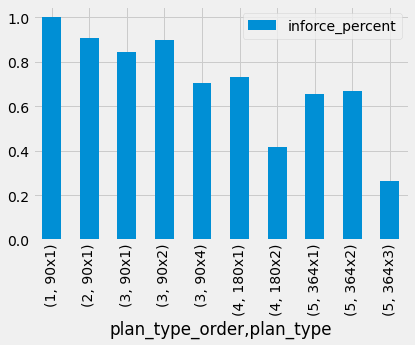

In [9]:
model_df.groupby(['plan_type_order', 'plan_type']).mean()[['inforce_percent']].plot.bar()

In [10]:
model_df['duration_inforce_adj'] = round(model_df['duration_inforce'], -1)

model_df.head()

<ipython-input-10-121557e286f2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df['duration_inforce_adj'] = round(model_df['duration_inforce'], -1)


,app_pid,plan_type_order,plan_type,plan_group,duration_sold,duration_inforce,inforce_percent,sold_month,sold_year,has_dental,has_vision,has_supp,plan_members,primary_age,child_age_average,state,duration_inforce_adj
0,186762,5,364x1,364,364,363,0.9972,12,2018,0,0,0,1,49.7700,nan,NC,360
1,207263,5,364x1,364,364,30,0.0824,5,2019,0,0,0,1,19.6200,nan,TX,30
2,195305,5,364x1,364,364,364,1.0000,2,2019,0,0,0,1,28.7000,nan,TX,360
3,206006,4,180x1,180,180,30,0.1666,5,2019,0,0,0,1,34.1100,nan,TN,30
4,211665,5,364x1,364,364,364,1.0000,6,2019,0,0,0,1,23.9800,nan,GA,360


<AxesSubplot:xlabel='duration_inforce_adj'>

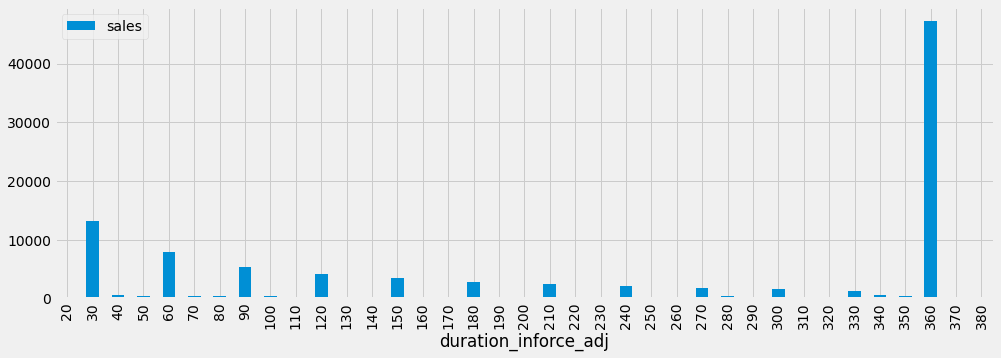

In [11]:
resamples = 100000

model_df[(model_df['plan_type'] == '364x1')]\
    .sample(resamples, replace=True)\
    .groupby('duration_inforce_adj').size().reset_index(name='sales')\
    .set_index('duration_inforce_adj').plot.bar(figsize=(15,5))

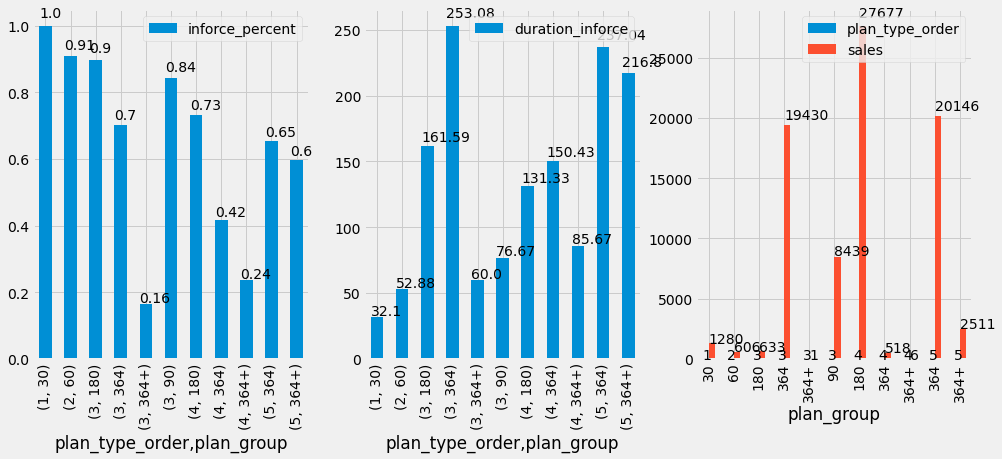

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,6))

model_df.groupby(['plan_type_order', 'plan_group']).mean()[['inforce_percent']].plot.bar(ax=ax[0])
model_df.groupby(['plan_type_order', 'plan_group']).mean()[['duration_inforce']].plot.bar(ax=ax[1])
model_df.groupby(['plan_type_order', 'plan_group']).size().reset_index(name='sales').plot.bar(x='plan_group', ax=ax[2])

for axs in ax:
    for p in axs.patches:
        axs.annotate(
            str(round(p.get_height(), 2)), 
            (p.get_x() * 1.00, 
             p.get_height() * 1.025)
        )
        


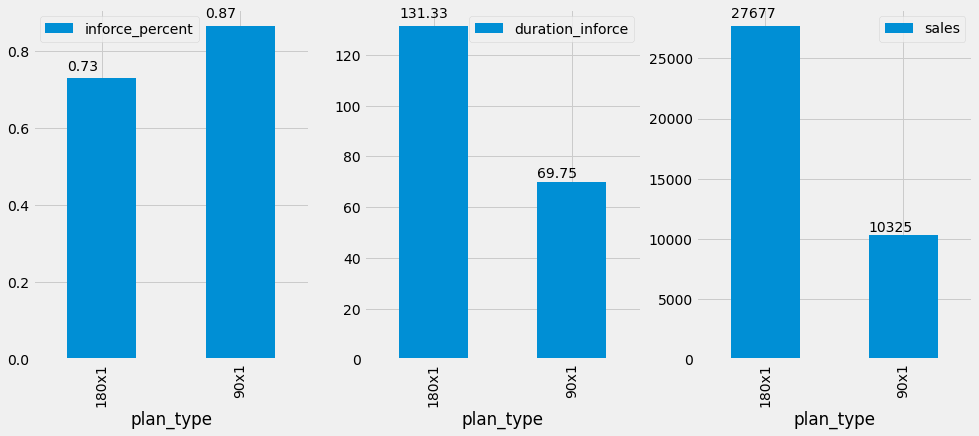

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,6))

slice_df = model_df[model_df['plan_type'].isin(['90x1', '180x1'])]

slice_df.groupby(['plan_type']).mean()[['inforce_percent']].plot.bar(ax=ax[0])
slice_df.groupby(['plan_type']).mean()[['duration_inforce']].plot.bar(ax=ax[1])
slice_df.groupby(['plan_type']).size().reset_index(name='sales').plot.bar(x='plan_type', ax=ax[2])

for axs in ax:
    for p in axs.patches:
        axs.annotate(
            str(round(p.get_height(), 2)), 
            (p.get_x() * 1.00, 
             p.get_height() * 1.025)
        )
        


In [14]:
model_df.groupby(['plan_type']).size().reset_index(name='sales').set_index('plan_type')[['sales']]

,sales
plan_type,
180x1,27677
180x2,524
364x1,20381
364x2,1804
364x3,472
90x1,10325
90x2,633
90x4,19431


<AxesSubplot:xlabel='plan_type'>

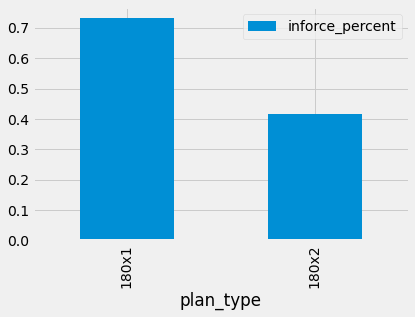

In [15]:
model_df[model_df['plan_type'].isin(['180x1', '180x2'])]\
    .groupby(['plan_type']).mean()[['inforce_percent']].plot.bar()

In [16]:
model_df[model_df['plan_type'].isin(['180x1', '180x2'])]\
    .groupby(['plan_type']).size().reset_index(name='counts')

,plan_type,counts
0,180x1,27677
1,180x2,524


<AxesSubplot:xlabel='plan_group'>

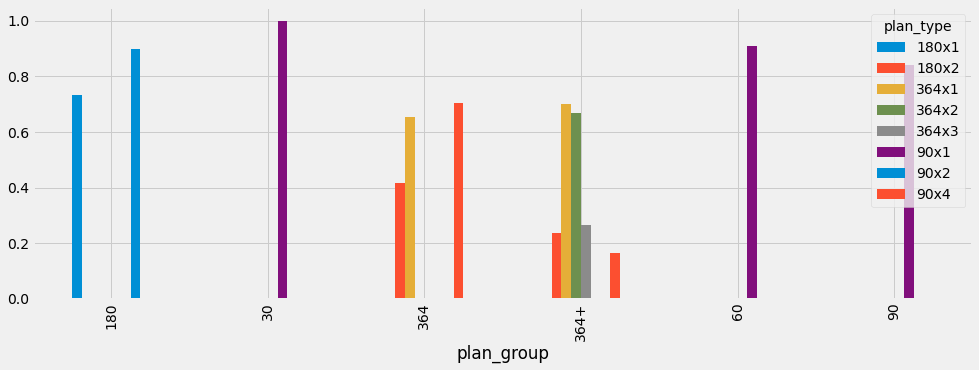

In [17]:
model_df.groupby(['plan_type', 'plan_group']).mean()[['inforce_percent']].reset_index()\
    .pivot_table(index='plan_group', columns='plan_type', values='inforce_percent')\
    .plot.bar(figsize=(15,5))

<ErrorbarContainer object of 3 artists>

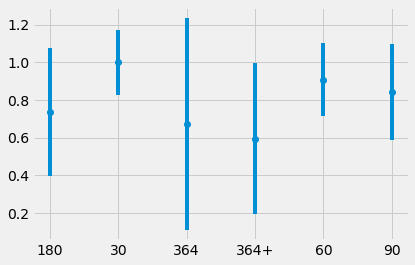

In [18]:
slice_df = model_df.groupby(['plan_group']).agg(['mean', 'std'])[['inforce_percent']]

slice_df = slice_df.inforce_percent.reset_index().set_index('plan_group')

plt.errorbar(x=slice_df.index, y=slice_df['mean'], yerr=slice_df['std'], fmt='o')

In [41]:
model_df.groupby(['plan_group']).mean()[['inforce_percent']]

,inforce_percent
plan_group,
180,0.7353
30,0.9996
364,0.6741
364+,0.5946
60,0.9080
90,0.8418


<AxesSubplot:xlabel='duration_inforce', ylabel='duration_sold'>

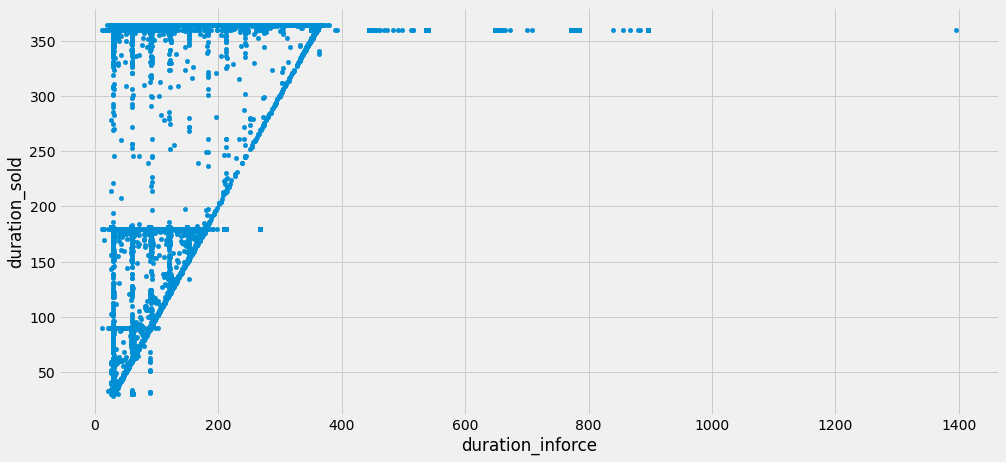

In [20]:
model_df[['duration_sold', 'duration_inforce']].plot.scatter(
    y='duration_sold', x='duration_inforce', figsize=(15,7)
)

In [21]:
slice_df = model_df.groupby(['plan_group']).size().reset_index(name='sales')
list(slice_df[slice_df['sales'] >= 200]['plan_group'])

['180', '30', '364', '364+', '60', '90']

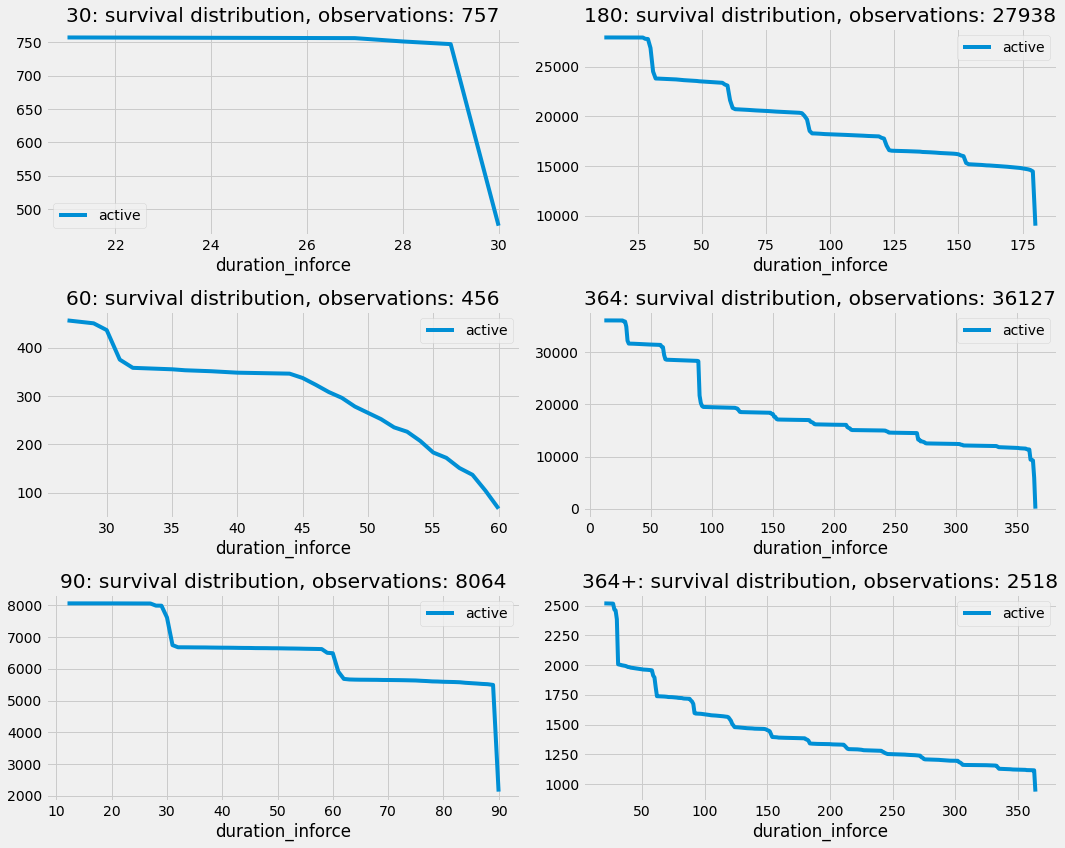

In [22]:
def plot_cumulative(df, category, ax, limit_days):

    df = df[df['duration_inforce'] <= limit_days]
    
    observations = len(df[df['plan_group'] == category])
    
    df[df['plan_group'] == category].groupby(['duration_inforce']).size().reset_index(name='active')\
        .sort_values(by='duration_inforce', ascending=False).set_index('duration_inforce')[['active']].cumsum()\
    .plot(ax=ax, title=f'{category}: survival distribution, observations: {observations}')

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))

plot_cumulative(df=model_df, category='30', ax=ax[0][0], limit_days=30)
plot_cumulative(df=model_df, category='60', ax=ax[1][0], limit_days=60)
plot_cumulative(df=model_df, category='90', ax=ax[2][0], limit_days=90)
plot_cumulative(df=model_df, category='180', ax=ax[0][1], limit_days=180)
plot_cumulative(df=model_df, category='364', ax=ax[1][1], limit_days=365)
plot_cumulative(df=model_df, category='364+', ax=ax[2][1], limit_days=365)

fig.tight_layout()
plt.show()

<AxesSubplot:title={'center':'Active Policies by Days since Effective Date: 364x1 plans'}, xlabel='duration_inforce'>

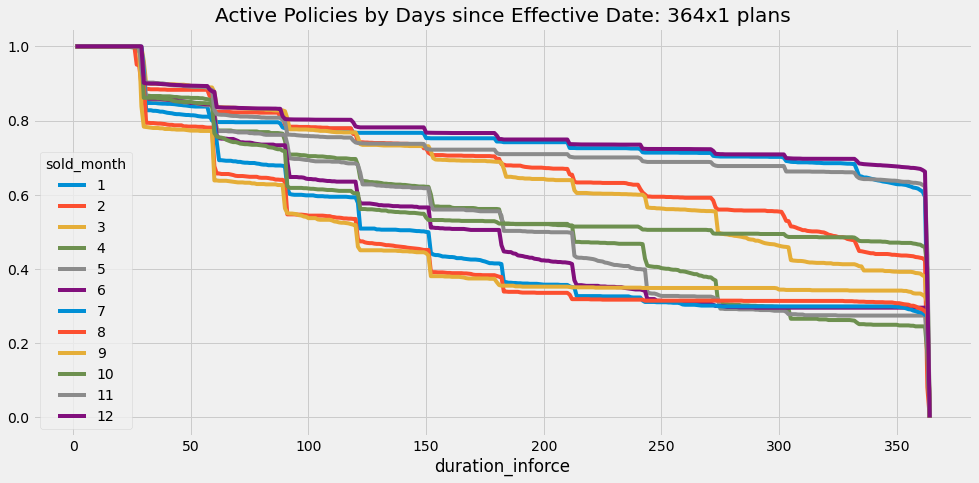

In [23]:
plan_category = '364x1'
duration_max = 364

base_df = model_df[(model_df['plan_type'] == plan_category) & (model_df['duration_inforce'] <= duration_max)]\
    .groupby(['sold_month','duration_inforce'])\
    .size().reset_index(name='active')

month_totals_df = base_df.groupby('sold_month').sum()[['active']].rename(columns={'active': 'total'}).reset_index()

dist_df = base_df.sort_values(by=['sold_month', 'duration_inforce'], ascending=True)


df_data =list()
for month in range(1, 13):
    for day in range(1, duration_max + 1):
        df_data.append([month, day])
        
alldays_df = pd.DataFrame(df_data, columns=['sold_month', 'duration_inforce'])
dist_df = dist_df.merge(alldays_df, on=['sold_month', 'duration_inforce'], how='right')

dist_df = dist_df.sort_values(by=['sold_month', 'duration_inforce'], ascending=True)\
    .groupby(['sold_month', 'duration_inforce'], sort=False).sum()\
    .groupby(level=0, sort=False).cumsum()[['active']].reset_index()
    
dist_df = dist_df.merge(month_totals_df)
dist_df['active'] = (dist_df['total'] - dist_df['active']) / dist_df['total']
dist_df.rename(columns={'active': 'percent_active'}, inplace=True)
dist_df.sort_values(by=['sold_month', 'duration_inforce'], inplace=True)

month_df = dist_df.pivot_table(index='duration_inforce', columns='sold_month', values='percent_active')
month_df.plot(figsize=(15,7), title=f'Active Policies by Days since Effective Date: {plan_category} plans')

In [31]:
    model_df[model_df['plan_type'] == '180x1'].groupby('sold_month')[['inforce_percent']].mean()\
        .reset_index().sort_values(by='inforce_percent', ascending=True)

,sold_month,inforce_percent
10,11,0.6158
9,10,0.6318
8,9,0.7027
11,12,0.7099
7,8,0.7124
1,2,0.7385
0,1,0.7523
6,7,0.7584
2,3,0.7817
4,5,0.7818


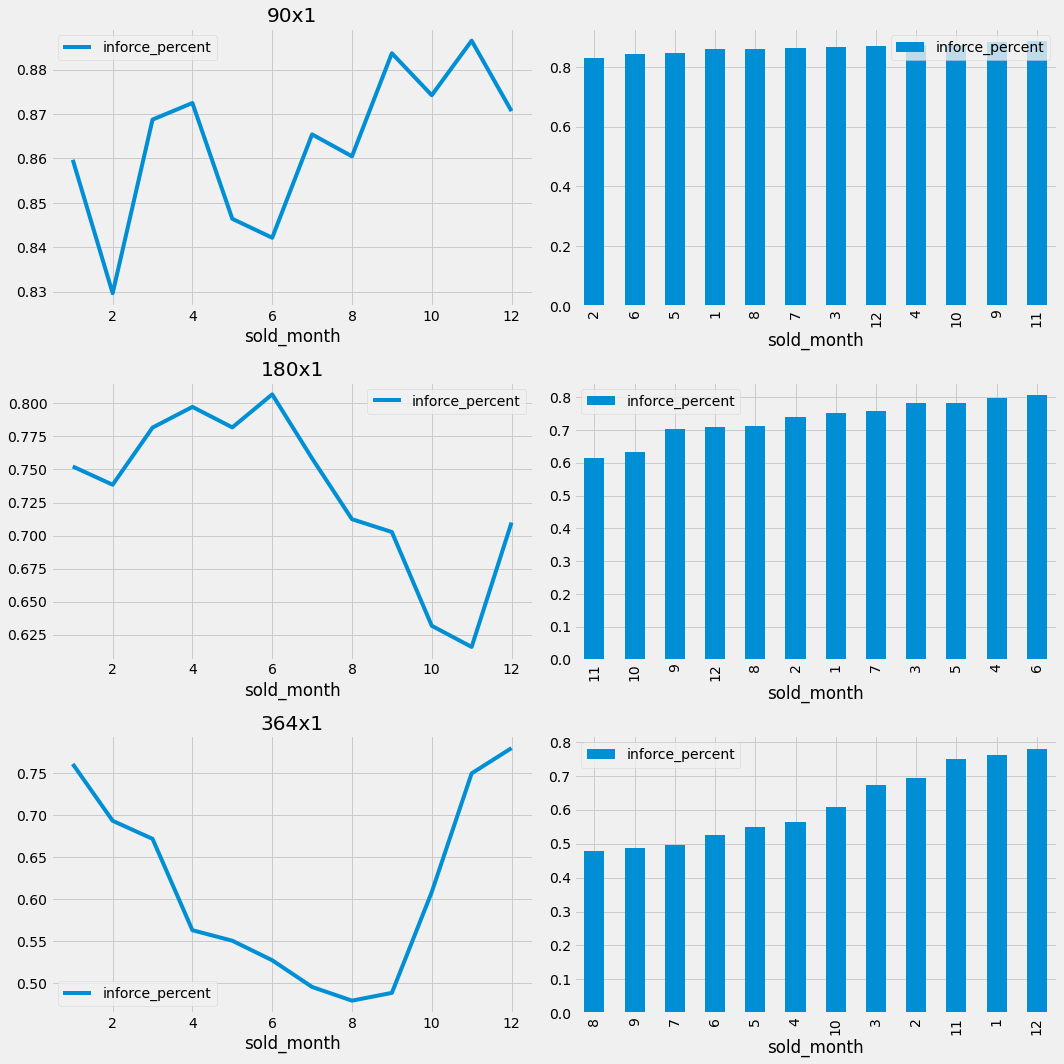

In [25]:
plans = ['90x1', '180x1', '364x1']

fig, ax = plt.subplots(nrows=len(plans), ncols=2, figsize=(15, 5 * len(plans)))


for fig_row, plan_category in enumerate(plans):
    
    model_df[model_df['plan_type'] == plan_category].groupby('sold_month')[['inforce_percent']].mean()\
        .plot(ax=ax[fig_row][0], title=plan_category)

    model_df[model_df['plan_type'] == plan_category].groupby('sold_month')[['inforce_percent']].mean()\
        .reset_index().sort_values(by='inforce_percent', ascending=True)\
        .plot.bar(x='sold_month', y='inforce_percent', ax=ax[fig_row][1])


fig.tight_layout()



<AxesSubplot:title={'center':'Duration by Age'}, xlabel='age_est'>

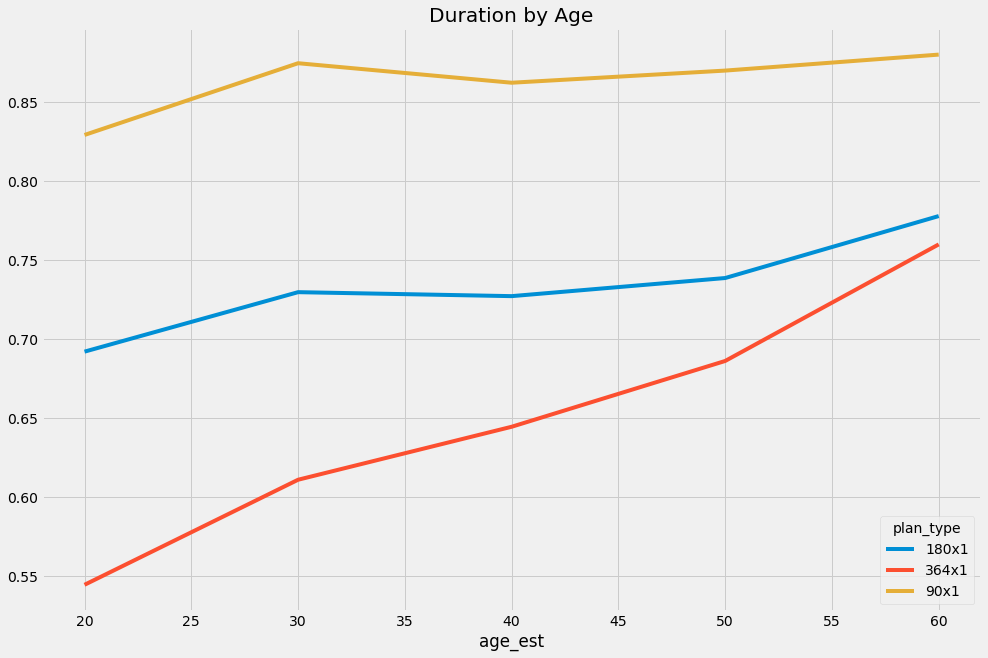

In [28]:
plans = ['90x1', '180x1', '364x1']

age_df = model_df[model_df['plan_type'].isin(plans)].copy()
age_df['age_est'] = round(age_df['primary_age'], -1)
age_df.groupby(['plan_type','age_est'])[['inforce_percent']].mean().reset_index()\
    .pivot_table(index='age_est', columns='plan_type', values='inforce_percent')\
    .plot(figsize=(15, 10), title='Duration by Age')

In [29]:
age_df.groupby(['plan_type','age_est'])[['inforce_percent']].size()

plan_type  age_est
180x1      20.0000    4336
           30.0000    7473
           40.0000    3535
           50.0000    3967
           60.0000    4902
364x1      20.0000    2956
           30.0000    5473
           40.0000    2943
           50.0000    3618
           60.0000    4134
90x1       20.0000    1622
           30.0000    2806
           40.0000    1479
           50.0000    1456
           60.0000    2161
dtype: int64

<AxesSubplot:title={'center':'Duration Take Rate by Month (2020 Only)'}, xlabel='sold_month'>

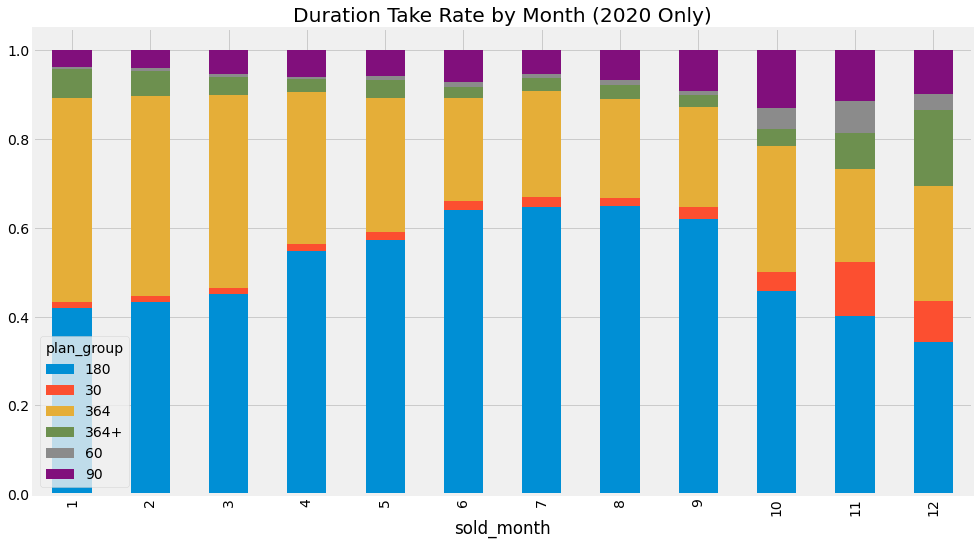

In [63]:
span_df = stm_df[stm_df['sold_year'] == 2020]

span_df = span_df.groupby(['sold_month', 'plan_group']).size().reset_index(name='policies')


span_df = span_df.groupby(['sold_month', 'plan_group']).sum() / span_df.groupby(['sold_month']).sum()[['policies']]

fig, ax = plt.subplots(nrows=1, ncols=1, facecolor='white')

span_df.pivot_table(
        index=['sold_month'],
        columns=['plan_group'],
        values='policies'
    ).plot.bar(stacked=True, figsize=(15,8), title='Duration Take Rate by Month (2020 Only)', ax=ax)



<AxesSubplot:xlabel='state'>

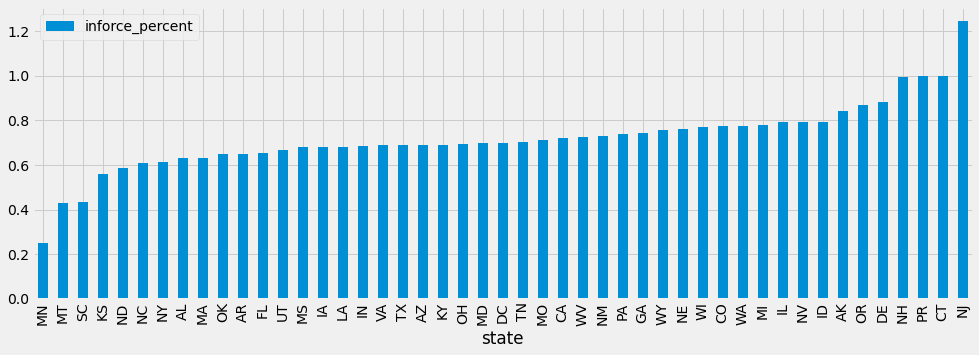

In [68]:
state_df = model_df.groupby('state')[['inforce_percent']].mean().reset_index()

state_df = model_df.groupby('state').size().reset_index(name='policies').set_index('state').reset_index()\
    .merge(state_df, how='inner', on='state').sort_values(by='inforce_percent').set_index('state')

state_df[['inforce_percent']].plot.bar(figsize=(15,5))

<AxesSubplot:xlabel='state'>

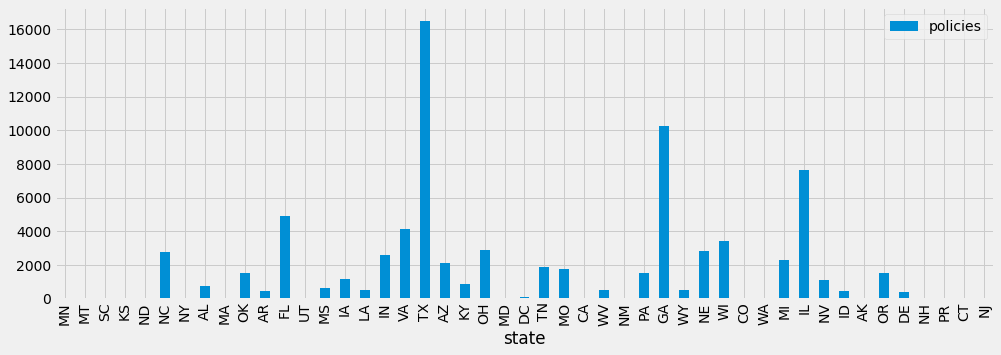

In [69]:
state_df[['policies']].plot.bar(figsize=(15,5))